In [6]:
import numpy as np
import matplotlib.pyplot as plt

def schwefel(*x):
    d = len(x)

    res = 0 * x[0]

    for xi in x:
        res += xi * np.sin(np.sqrt(np.abs(xi)))

    return 418.9829 * d - res




In [ ]:
schwefel(0, 0)

837.9658

In [9]:
x = np.array([0, 1], dtype=float)
y = np.array([0, 1], dtype=float)
schwefel(x, y)

array([837.9658    , 836.28285803])

In [22]:
x = np.linspace(-500, 500, 1000)
y = np.linspace(500, -500, 1000)

X, Y = np.meshgrid(x, y)
Y

array([[ 500.      ,  500.      ,  500.      , ...,  500.      ,
         500.      ,  500.      ],
       [ 498.998999,  498.998999,  498.998999, ...,  498.998999,
         498.998999,  498.998999],
       [ 497.997998,  497.997998,  497.997998, ...,  497.997998,
         497.997998,  497.997998],
       ...,
       [-497.997998, -497.997998, -497.997998, ..., -497.997998,
        -497.997998, -497.997998],
       [-498.998999, -498.998999, -498.998999, ..., -498.998999,
        -498.998999, -498.998999],
       [-500.      , -500.      , -500.      , ..., -500.      ,
        -500.      , -500.      ]])

In [23]:
Z = schwefel(X, Y)
Z

array([[ 837.9658    ,  848.7920513 ,  859.67188675, ..., 1177.43803032,
        1188.31786577, 1199.14411706],
       [ 827.1395487 ,  837.9658    ,  848.84563545, ..., 1166.61177902,
        1177.49161447, 1188.31786577],
       [ 816.25971325,  827.08596455,  837.9658    , ..., 1155.73194357,
        1166.61177902, 1177.43803032],
       ...,
       [ 498.49356968,  509.31982098,  520.19965643, ...,  837.9658    ,
         848.84563545,  859.67188675],
       [ 487.61373423,  498.43998553,  509.31982098, ...,  827.08596455,
         837.9658    ,  848.7920513 ],
       [ 476.78748294,  487.61373423,  498.49356968, ...,  816.25971325,
         827.1395487 ,  837.9658    ]])

(-0.5, 999.5, 999.5, -0.5)

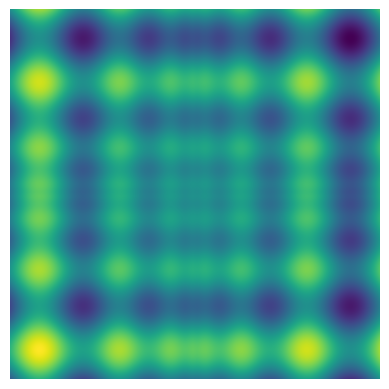

In [24]:
fig, ax = plt.subplots()

img = ax.imshow(Z)
ax.axis("off")

In [25]:
rng = np.random.default_rng(123456789)

In [35]:
init = rng.uniform(0, 1000, size=(2, 10))

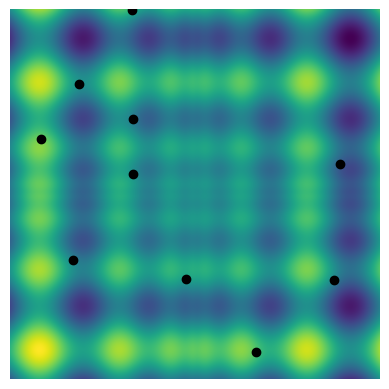

In [36]:
fig, ax = plt.subplots()

img = ax.imshow(Z)
ax.axis("off")

ax.scatter(init[0], init[1], color="k")

In [32]:
plt.show()